# Chapter 14: Penalized regression
https://ds-ml-with-python.github.io/Course-Textbook/13-penalized_regression.html

In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
# Read the data
ames = pd.read_csv("/Users/andriy/Desktop/GSB544_ML/Week_7/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [3]:
# Set up the pipeline

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [7]:
lr_cv_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
print ("OLR CV mean R-squared score:", np.mean(lr_cv_scores))
# overfit model

OLR CV mean R-squared score: -1.5843273043067347e+22
OLR CV mean R-squared score: -1.5843273043067347e+22


## Ridge regression

Regularization - add a new piece to our loss function that restricts the flexibility of the Beta's. We call these new pieces penalties.

SSE + adding sum of Beta_js^2 - Ridge penalty, another name for the sum of squared coefficients.

Now our loss function - which defines the best betas - has two concerns:
1. To make the Sum of Squared Error (SSE) small
2. To make the betas themselves small

These two concerns are acting in opposition to each other: We can make the SSE small by choosing Bet’s that overfit; or we can make the Ridge penalty small by choosing Beta’s near 0, but we can’t do both at the same time.

To decide how much we want to prioritize each concern, we’ll throw a number in called 'lambda' ('alpha' parameter in Ridge regression).

Now, we have a “knob” we can use to balance the pieces of the loss function. If 'lambda' is very large, then we care much more about restricting our coefficients to small values than about getting small SSE. If 'lambda' is close to 0, then we care much more about SSE.

When Beta’s are chosen according to the above loss function, instead of just considering SSE, we call this Ridge Regression.

### PA 1:

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lambda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

The 'sklearn' function 'Ridge()' uses the argument name 'alpha' for lambda.

In [8]:
# Piepline for Ridge with lambda (alpha) = 1 # Assisted by ChatGPT

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
    ("ridge_regresssion", Ridge (alpha=1))]
)

# Cross-validate the Ridge pipeline

ridge_cv_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')
print('Ridge Regression CV mean R-squared score:', np.mean(ridge_cv_scores))


Ridge Regression CV mean R-squared score: 0.8619316345217353
Ridge Regression CV mean R-squared score: 0.8619316345217353


In [9]:
# Fit both models on the dataset

lr_pipeline_1.fit(X, y)
ridge_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1146d2de0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1146d29f0>)])),
                ('ridge_regresssion', Ridge(alpha=1))])

In [11]:
# Extract coefficients for both models and create a dataframe

# LR
lr_coefficients = lr_pipeline_1.named_steps['linear_regression'].coef_

# Ridge
feature_names = ridge_pipeline.named_steps['preprocessing'].get_feature_names_out()
ridge_coefficients = ridge_pipeline.named_steps['ridge_regresssion'].coef_

# Create a Dataframe for comparison
coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Linear Regression Coefficients": lr_coefficients,
    "Ridge Coefficients": ridge_coefficients
})


In [15]:
coeff_df.head()

,Feature,Linear Regression Coefficients,Ridge Coefficients
0,dummify__MS Zoning_C (all),-1.679759e+17,-5585.147072
1,dummify__MS Zoning_FV,-1.679759e+17,1279.599730
2,dummify__MS Zoning_I (all),-1.679759e+17,-5465.717759
3,dummify__MS Zoning_RH,-1.679759e+17,7876.141644
4,dummify__MS Zoning_RL,-1.679759e+17,3046.095382


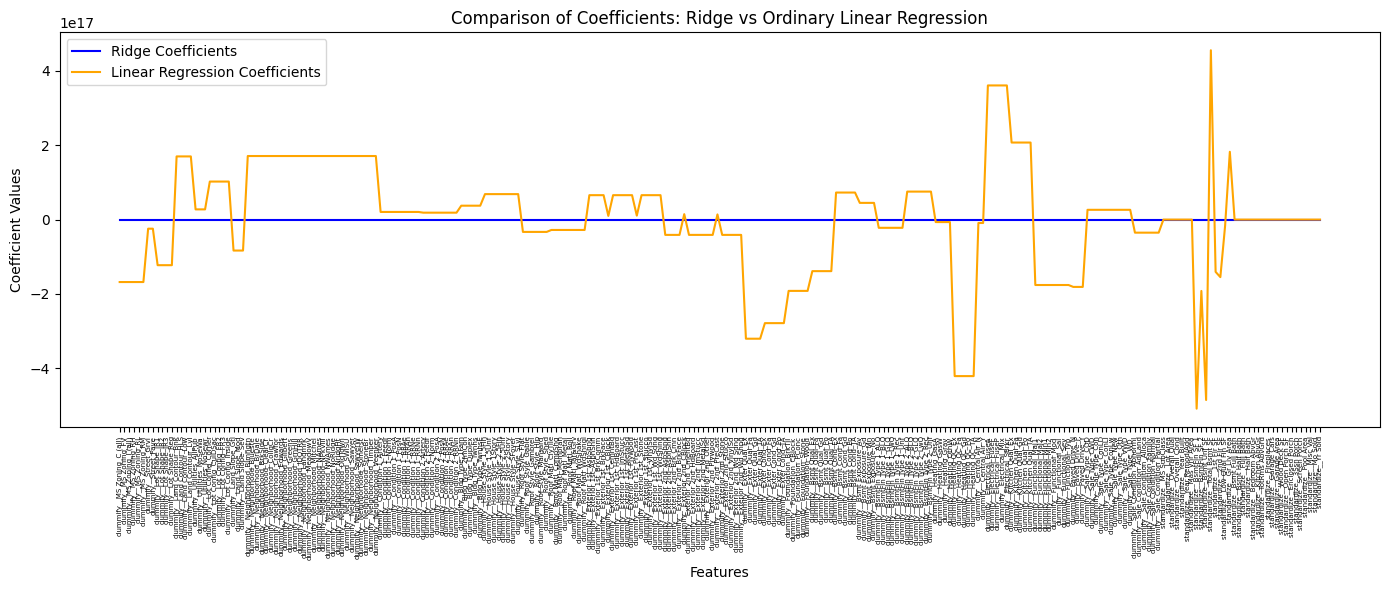

In [14]:
# Plot coefficients # Assisted by ChatGPT

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(coeff_df["Feature"], coeff_df["Ridge Coefficients"], label="Ridge Coefficients", color='blue')
plt.plot(coeff_df["Feature"], coeff_df["Linear Regression Coefficients"], label="Linear Regression Coefficients", color='orange')
plt.xticks(rotation=90, fontsize=5)
plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Comparison of Coefficients: Ridge vs Ordinary Linear Regression")
plt.legend()
plt.tight_layout()
plt.show()


## PA 2: Using the same pipeline as previously, perform tuning on 'lambda'

You should always try 'lambda' values on a log scale eg. [0.001, 0.01, 0.1, 1, 10]

In [49]:
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
    ("ridge_regression", Ridge())]
)

degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.02824049, 0.02955279, 0.02551212, 0.02588964, 0.0305676 ]),
 'std_fit_time': array([0.0020235 , 0.00216983, 0.00043648, 0.00090419, 0.00537299]),
 'mean_score_time': array([0.00856757, 0.0089859 , 0.00871873, 0.0085134 , 0.00938234]),
 'std_score_time': array([0.00039376, 0.00076013, 0.00051627, 0.00054807, 0.00038527]),
 'param_ridge_regression__alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'ridge_regression__alpha': 0.001},
  {'ridge_regression__alpha': 0.01},
  {'ridge_regression__alpha': 0.1},
  {'ridge_regression__alpha': 1},
  {'ridge_regression__alpha': 10}],
 'split0_test_score': array([0.8972854 , 0.89734306, 0.89774358, 0.89815807, 0.8977621 ]),
 'split1_test_score': array([0.91040618, 0.91061417, 0.91230557, 0.91744024, 0.92081211]),
 'split2_test_score': array([0.78901601, 0.7891259 , 0.79010977, 0.79493606, 0.80057243]),
 'split3_test_score'

In [50]:
ridge_scores_df = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores_Ridge": gscv_fitted.cv_results_['mean_test_score']})

The best R-squared scored is at lambda = 10.

## Lasso

(least absolute shrinkage and selection operator) penalty - regularizes the Beta’s according to their absolute value instead of the square.

This outcome, where some of the Beta’s are fully eliminated from the model, is very powerful. It essentially performs automatic feature selection; the predictors whose coefficients became zero are the ones that were not needed to get better predictive power.

## PA 3: Create a LASSO pipeline, and tune 'lambda'

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

The sklearn function Lasso() uses the argument name alpha for lambda.

In [51]:
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lasso_regression", Lasso())]
)

degrees = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(lasso_pipeline, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


{'mean_fit_time': array([0.80902839, 0.82054424, 0.79504943, 0.73339677, 0.2356802 ]),
 'std_fit_time': array([0.02631857, 0.02586257, 0.02767847, 0.19504609, 0.10465016]),
 'mean_score_time': array([0.00969439, 0.01021652, 0.00921721, 0.00899515, 0.00988746]),
 'std_score_time': array([0.00119585, 0.00035829, 0.00019891, 0.00050468, 0.00117621]),
 'param_lasso_regression__alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'lasso_regression__alpha': 0.001},
  {'lasso_regression__alpha': 0.01},
  {'lasso_regression__alpha': 0.1},
  {'lasso_regression__alpha': 1},
  {'lasso_regression__alpha': 10}],
 'split0_test_score': array([0.8972019 , 0.89720561, 0.89725821, 0.89774385, 0.90077569]),
 'split1_test_score': array([0.9103958 , 0.91040134, 0.91045103, 0.91093785, 0.91506699]),
 'split2_test_score': array([0.79032004, 0.79085941, 0.79595065, 0.79691806, 0.80141962]),
 'split3_test_score'

In [52]:
lasso_scores_df = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores_Lasso": gscv_fitted.cv_results_['mean_test_score']})

In [55]:
pen_scores = pd.merge(ridge_scores_df, lasso_scores_df, on='degrees')
pen_scores['lasso/ridge'] = pen_scores['scores_Lasso'] / pen_scores['scores_Ridge'] - 1
pen_scores

,degrees,scores_Ridge,scores_Lasso,lasso/ridge
0,0.001,0.853920,0.855499,0.001849
1,0.010,0.854186,0.855606,0.001662
2,0.100,0.856302,0.856618,0.000369
3,1.000,0.861932,0.857152,-0.005545
4,10.000,0.864272,0.860632,-0.004212


Lasso scores are slightly better than Ridge for degrees <1. But the overall best score is still, Ridge at 10 degrees.

## Elastic Net

Adds both 'Ridge' and 'Lasso' penalties to our loss function, and a parameter 'alpha' (named 'l1_ratio' in scikitlearn) to regulate lean between Ridge vs Lasso penalties.

### PA 4: Create an Elastic Net pipeline, and tune 'lambda' and 'alpha'.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [62]:
elasticnet_pipeline = Pipeline(
    [("preprocessing", ct),
    ("elasticnet_regression", ElasticNet())]
)

degrees = {
    'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elasticnet_regression__l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7]
}

gscv = GridSearchCV(elasticnet_pipeline, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.512e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.306e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.145e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.392e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.282e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.466e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.259e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.122e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.353e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.237e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.347e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.137e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.068e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.249e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.119e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.975e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.005e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.109e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.963e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.963e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.737e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.928e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.897e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.734e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+09, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+10, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.603e+09, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e+09, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.277e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.999e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.789e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.184e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.943e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e+09, tolerance: 1.793e+09
  model = cd_fast.enet_coordinate_descent(


{'mean_fit_time': array([0.79465079, 0.7751204 , 0.77736998, 0.78943367, 0.85938363, 0.6333262 , 0.56683302, 0.65058203, 0.77440643, 0.7776875 ,
        0.1342298 , 0.11861911, 0.12190166, 0.1269649 , 0.15017886, 0.05249376, 0.05007982, 0.05280495, 0.05719304, 0.0662498 ,
        0.03172789, 0.03132377, 0.03067765, 0.03153162, 0.0338088 ]),
 'std_fit_time': array([0.03082443, 0.01859237, 0.02062337, 0.02805957, 0.09884367, 0.02687957, 0.01431456, 0.03274164, 0.02237723, 0.02058564,
        0.00580704, 0.00588763, 0.00571046, 0.00328544, 0.00408397, 0.00220137, 0.0007117 , 0.00088478, 0.00130162, 0.00229843,
        0.00018017, 0.00035736, 0.00011477, 0.00064914, 0.00040479]),
 'mean_score_time': array([0.00925961, 0.00909848, 0.00902019, 0.00923061, 0.009693  , 0.0103312 , 0.00863886, 0.00893302, 0.00863585, 0.00907645,
        0.00969019, 0.00841241, 0.00890188, 0.00827227, 0.00865417, 0.00805621, 0.00827818, 0.00802088, 0.00878601, 0.00848889,
        0.00833473, 0.00810542, 0.008289

In [63]:
# dataframe for the Elastic Net scores results # Assisted by ChatGPT

# extract data from the fitted grid search
alphas = gscv_fitted.cv_results_['param_elasticnet_regression__alpha'].data
l1_ratios = gscv_fitted.cv_results_['param_elasticnet_regression__l1_ratio'].data
mean_scores = gscv_fitted.cv_results_['mean_test_score']

elasticnet_scores_df = pd.DataFrame({
    "degrees_lambda": alphas, 
    "degrees_alpha": l1_ratios,
    "scores_ElasticNet": mean_scores
    })

elasticnet_scores_df.sort_values(by='scores_ElasticNet', ascending=False)

,degrees_lambda,degrees_alpha,scores_ElasticNet
8,0.010,0.50,0.864268
9,0.010,0.70,0.864157
7,0.010,0.30,0.864119
6,0.010,0.10,0.863848
5,0.010,0.01,0.863703
0,0.001,0.01,0.863180
1,0.001,0.10,0.863061
2,0.001,0.30,0.862712
3,0.001,0.50,0.862155
4,0.001,0.70,0.861085


In [61]:
0.864268/0.864272 -1

-4.628172612375359e-06

ElasticNet Model 8: degrees_lambda = 0.010 and degrees_alpha = 0.5, has the highest R-squared score: 0.864268. This score is still slightly lower than Ridge at 10 degrees.